# Homework4, Daniil Glukhovskiy, 10/07/2020

## Data import

In [1]:
import qrpm_funcs as qf 
import numpy as np
#FRED codes for US Treasury constant maturity rates
seriesnames=['DGS1MO','DGS3MO','DGS6MO','DGS1','DGS2','DGS3','DGS5','DGS7','DGS10','DGS20','DGS30']
maturities=qf.TenorsFromNames(seriesnames)
dates,prices=qf.GetFREDMatrix(seriesnames,startdate='2019-01-02',enddate='2019-12-31')
#remove no-data periods
nobs, t = len(dates), 0
while t<nobs:
    if all(np.isnan(prices[t])):
        del prices[t]
        del dates[t]
        nobs -= 1
    else: 
        t += 1

## Problem 2

In [2]:
#Array of day-to-day price changes
price_changes = np.zeros((249,11))
for i in range(249):
    price_changes[i] = np.array(prices[i+1]) - np.array(prices[i])
#Covariance matrix of these changes and its eigenvalues
covariances = np.cov(price_changes.T)
eigval, eigvec = np.linalg.eigh(covariances)

In [3]:
#percentage of variance explained by three largest eigenvalues
sum(eigval[-3::])/np.trace(covariances)

0.9304656991073289

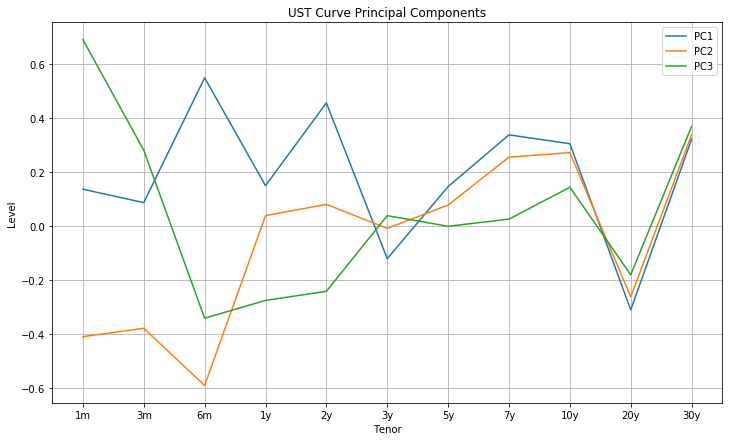

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 7]

#Plot first 3 principal components of covariance matrix
tenornames=['1m', '3m', '6m'] + [str(int(i)) + 'y' for i in maturities[3::]]
tenornumbers=range(11)
pc3, pc2, pc1 = eigvec[-3::]
plt.plot(tenornumbers, pc1, label='PC1')
plt.plot(tenornumbers, pc2, label='PC2')
plt.plot(tenornumbers, pc3, label='PC3')

## Configure the graph
plt.title('UST Curve Principal Components')
plt.xlabel('Tenor')
plt.ylabel('Level')
plt.legend()
plt.xticks(tenornumbers, tenornames)
plt.grid(True)
plt.show;

## Problem 3

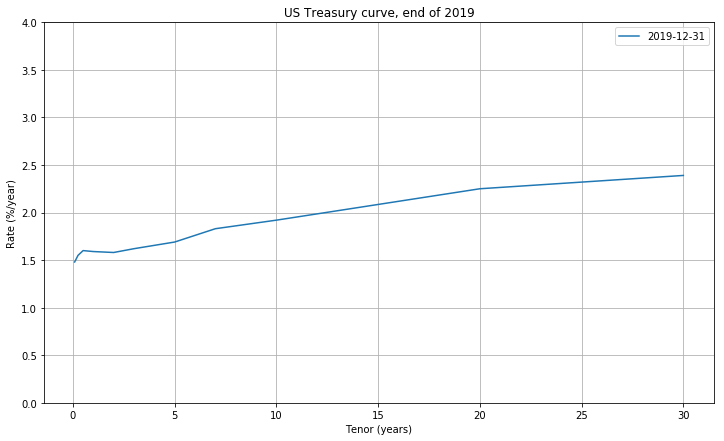

In [5]:
#Plot US Treasury yield curve 
plt.rcParams['figure.figsize'] = [12, 7]
tenornames=maturities
tenornumbers=range(11)
last_day = prices[-1]
plt.plot(maturities, last_day, label=dates[-1])

## Configure the graph
plt.title('US Treasury curve, end of 2019')
plt.xlabel('Tenor (years)')
plt.ylabel('Rate (%/year)')
plt.ylim(0,4)
plt.legend()
plt.grid(True)
plt.show;

In [6]:
#Creating linear interpolation between known rates at known maturities
import scipy.interpolate
y_interp = scipy.interpolate.interp1d(maturities, last_day)
straight_line = [float(i) for i in y_interp(np.arange(1/12, 30, 1/12))]

In [7]:
#Defining Nelson-Siegel function.
def nels_sieg(f, beta_0, beta_1, beta_2, tau):
    return beta_0 + beta_1*tau*(1/f)*(1 - np.exp(-f/tau)) + beta_2*tau*(1/f)*(1-(1+f/tau)*np.exp(-f/tau))

In [8]:
#Fitting the parameters
from scipy.optimize import curve_fit
popt, pcov = curve_fit(nels_sieg, np.arange(1,361), straight_line)

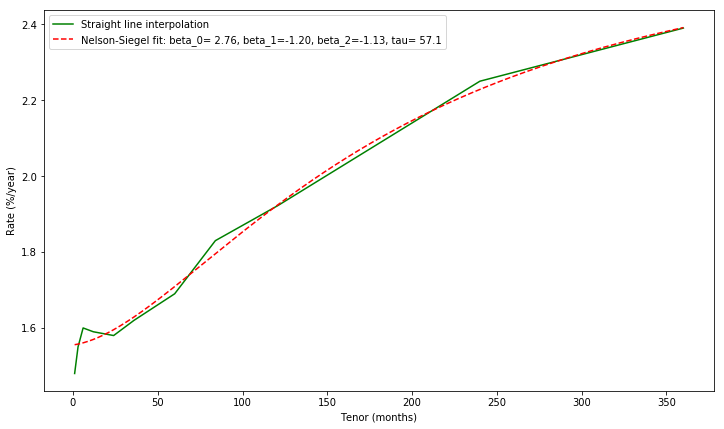

In [9]:
#Plotting fitted curve and straight-line interpolation.
plt.rcParams['figure.figsize'] = [12, 7]
plt.plot(np.arange(1,361), straight_line, 'g-', label='Straight line interpolation')
plt.plot(np.arange(1,361), nels_sieg(np.arange(1,361), *popt), 'r--',
         label='Nelson-Siegel fit: beta_0=%5.2f, beta_1=%5.2f, beta_2=%5.2f, tau=%5.1f' % tuple(popt))
plt.xlabel('Tenor (months)')
plt.ylabel('Rate (%/year)')
#plt.ylim(0,4)
plt.legend()
plt.show()